In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class BaseBlock(nn.Module):
  expansion=1
  def __init__(self,in_planes,planes,stride=1,dimens=None):
    super(BaseBlock,self).__init__()
    """
    Declaring convolutional layers with Batch norms
    """
    self.conv1 = nn.Conv2d(in_planes,planes,stride = stride,kernel_size=3,padding=1)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
    self.bn2 = nn.BatchNorm2d(planes)
    self.dimens = dimens

  def forward(self,x):
    res = x
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))

    if self.dimens is not None:
      res = self.dimens(res)

    out +=res 
    out = F.relu(out)
    return out



In [3]:
class BottleNeck(nn.Module):
  expansion=4
  def __init__(self,in_planes,planes,stride=1,dimens=None):
  
    super(BottleNeck,self).__init__()
    self.conv1 = nn.Conv2d(in_planes,planes,stride=1,kernel_size=1)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes,planes,kernel_size=3,stride=stride,padding=1)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes,planes*self.expansion,kernel_size=1)
    self.bn3 = nn.BatchNorm2d(planes*self.expansion)
    self.dimens = dimens



  def forward(self,x):
    res = x
    out =F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))

    if self.dimens is not None:
      res = self.dimens(res)
    out +=res
    out =F.relu(out)
    return out


In [4]:
class ResNet(nn.Module):
  def __init__(self,block,num_layers,classes=10):
    super(ResNet,self).__init__()
    self.in_planes = 64
    self.conv1 = nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1)
    self.bn1 = nn.BatchNorm2d(64)

    self.layer1 = self._make_layer(block,64,num_layers[0],stride=1)
    self.layer2 = self._make_layer(block,128,num_layers[1],stride=2)
    self.layer3 = self._make_layer(block,256,num_layers[2],stride=2)
    self.layer4 = self._make_layer(block,512,num_layers[3],stride=2)
    self.averagepool = nn.AvgPool2d(kernel_size=4,stride=1)
    self.fc = nn.Linear(512*block.expansion,classes)


  def _make_layer(self,block,planes,num_layers,stride=1):
    dimens = None
    if stride !=1 or planes != self.in_planes*block.expansion:
      dimens = nn.Sequential(
          nn.Conv2d(self.in_planes,planes*block.expansion,kernel_size=1,stride=stride),
          nn.BatchNorm2d(planes*block.expansion)
      )

    netlayers = []
    netlayers.append(block(self.in_planes,planes,stride=stride,dimens=dimens))
    self.in_planes = planes*block.expansion
    for i in range(1,num_layers):
      netlayers.append(block(self.in_planes,planes))
      self.in_planes = planes*block.expansion
    return nn.Sequential(*netlayers)


  def forward(self,x):
    x = F.relu(self.bn1(self.conv1(x)))

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = F.avg_pool2d(x,4)
    x = x.view(x.size(0),-1)#convert from 3d to 2d
    x = self.fc(x)
    return x


In [6]:
def resnet101():
    layers=[3, 4, 23, 3]
    model = ResNet(BottleNeck,layers)
    return model

In [7]:
model=resnet101()


In [8]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dimens): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BottleNeck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
   

In [13]:
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
        )

#Load train and test set:
train = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(train,batch_size=128,shuffle=True)

test = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader = torch.utils.data.DataLoader(test,batch_size=128,shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [14]:
device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [15]:
train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(trainloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [16]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(testloader)
  accu=100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 



In [17]:
epochs=10
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 391/391 [10:26<00:00,  1.60s/it]


Train Loss: 0.738 | Accuracy: 73.790


100%|██████████| 79/79 [00:40<00:00,  1.95it/s]


Test Loss: 0.797 | Accuracy: 72.010

Epoch : 2


100%|██████████| 391/391 [10:25<00:00,  1.60s/it]


Train Loss: 0.656 | Accuracy: 76.854


100%|██████████| 79/79 [00:40<00:00,  1.95it/s]


Test Loss: 0.819 | Accuracy: 72.780

Epoch : 3


100%|██████████| 391/391 [10:26<00:00,  1.60s/it]


Train Loss: 0.598 | Accuracy: 78.962


100%|██████████| 79/79 [00:40<00:00,  1.95it/s]


Test Loss: 0.768 | Accuracy: 74.090

Epoch : 4


100%|██████████| 391/391 [10:28<00:00,  1.61s/it]


Train Loss: 0.527 | Accuracy: 81.706


100%|██████████| 79/79 [00:40<00:00,  1.94it/s]


Test Loss: 0.789 | Accuracy: 74.230

Epoch : 5


100%|██████████| 391/391 [10:32<00:00,  1.62s/it]


Train Loss: 0.435 | Accuracy: 84.878


100%|██████████| 79/79 [00:40<00:00,  1.93it/s]


Test Loss: 0.830 | Accuracy: 73.950

Epoch : 6


100%|██████████| 391/391 [10:32<00:00,  1.62s/it]


Train Loss: 0.330 | Accuracy: 88.574


100%|██████████| 79/79 [00:40<00:00,  1.93it/s]


Test Loss: 0.901 | Accuracy: 74.230

Epoch : 7


100%|██████████| 391/391 [10:32<00:00,  1.62s/it]


Train Loss: 0.229 | Accuracy: 92.366


100%|██████████| 79/79 [00:40<00:00,  1.93it/s]


Test Loss: 1.042 | Accuracy: 73.170

Epoch : 8


100%|██████████| 391/391 [10:32<00:00,  1.62s/it]


Train Loss: 0.156 | Accuracy: 94.680


100%|██████████| 79/79 [00:40<00:00,  1.93it/s]


Test Loss: 1.165 | Accuracy: 73.430

Epoch : 9


100%|██████████| 391/391 [10:32<00:00,  1.62s/it]


Train Loss: 0.120 | Accuracy: 95.878


100%|██████████| 79/79 [00:41<00:00,  1.92it/s]


Test Loss: 1.208 | Accuracy: 73.620

Epoch : 10


100%|██████████| 391/391 [10:36<00:00,  1.63s/it]


Train Loss: 0.094 | Accuracy: 96.806


100%|██████████| 79/79 [00:41<00:00,  1.92it/s]

Test Loss: 1.298 | Accuracy: 72.980


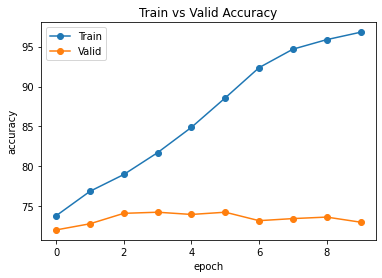

In [18]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

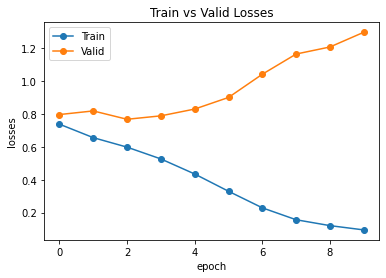

In [19]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [20]:
train_losses

[0.7381574827082017,
 0.6561662262053136,
 0.5982737085398506,
 0.526521349044712,
 0.43481628429096986,
 0.32969389108898084,
 0.22886353782604418,
 0.1562712992186589,
 0.12048650840702264,
 0.09438201098624245]

In [21]:
eval_losses

[0.7966794960106476,
 0.8187391531618335,
 0.7679197543029543,
 0.7888273521314694,
 0.8301582600496993,
 0.9007718087751654,
 1.042142296139198,
 1.1651468465599832,
 1.2080454222763641,
 1.2977669442756266]

In [22]:
train_accu

[73.79, 76.854, 78.962, 81.706, 84.878, 88.574, 92.366, 94.68, 95.878, 96.806]

In [23]:
eval_accu

[72.01, 72.78, 74.09, 74.23, 73.95, 74.23, 73.17, 73.43, 73.62, 72.98]